In [1]:
import torch
from torch.distributions import Beta, Binomial, Categorical, Gamma
from pyro.distributions import InverseGamma
from sbi.utils import MultipleIndependent, mcmc_transform
from sbi.inference.potentials.base_potential import BasePotential
from sbi.utils.torchutils import atleast_2d

# simulate

In [2]:
def simulate_choice_and_rt(params):
    """
    args:
        params - batch size x 2
    returns:
        (rt, choice)
    """
    betas, rhos = params[:, 0], params[:,1] # beta - for RT , rho - for choice
    choices =  Binomial(probs=rhos).sample().reshape(-1, 1)
    rts = InverseGamma(concentration=torch.ones_like(betas), rate=betas).sample().reshape(-1, 1)

    return torch.cat((rts, choices), 1)

# test the above func
params = torch.Tensor([[0.3, 0.5], [0.2, 0.5], [0.1, 0.5]])
print(simulate_choice_and_rt(params).shape)
print(simulate_choice_and_rt(params))

torch.Size([3, 2])
tensor([[0.1681, 1.0000],
        [1.5819, 0.0000],
        [0.4668, 0.0000]])


In [3]:
# Define independent prior.
prior = MultipleIndependent(
    [
        Gamma(torch.tensor([1.0]), torch.tensor([0.5])), # sample beta for RT distr-Inv.Gamma
        Beta(torch.tensor([2.0]), torch.tensor([2.0])), # sample rho for choice distr-binomial
    ],
    validate_args=False,
)

In [4]:
class PotentialFunc(BasePotential):
    def __init__(self, prior, x_o, device='cpu'):
        super().__init__(prior, x_o, device)
    
    def __call__(self, theta, track_gradients=True):
        theta = atleast_2d(theta)

        with torch.set_grad_enabled(track_gradients):
            iid_ll = self.iid_likelihood(theta)

        return iid_ll + self.prior.log_prob(theta) # prior + likelihood

    def iid_likelihood(self, theta):
        batch_size = theta.shape[0]
        num_trials = self.x_o.shape[0]

        theta = theta.reshape(batch_size, 1, -1)

        beta = theta[:, :, 0]
        rho = theta[:, :, 1]

        # u know how to calculate likelihood
        logprob_choice = Binomial(probs=rho).log_prob(
            self.x_0[:, 1].reshape(1, num_trials, -1)
        )
        logprob_rt = InverseGamma(
            concentration=torch.ones_like(beta), rate=beta
        ).log_prob(self.x_0[:, 0].reshape(1, num_trials, -1))

        joint_likelihood = (logprob_choice + logprob_rt).squeeze()

        return joint_likelihood.sum(dim=1)



# posterior

In [5]:
num_trials = 10
num_samples = 1000
theta_o = prior.sample((1,))

In [6]:
theta_o # beta, rho starting pt

tensor([[4.2575, 0.5076]])

In [7]:
x_o = simulate_choice_and_rt(theta_o.repeat(num_trials, 1))

In [8]:
x_o # num trials x 2, RT and choice

tensor([[ 4.7984,  0.0000],
        [19.3946,  0.0000],
        [ 9.1232,  0.0000],
        [ 8.4225,  0.0000],
        [15.6525,  0.0000],
        [70.1468,  1.0000],
        [ 2.8230,  1.0000],
        [12.6730,  1.0000],
        [91.1882,  0.0000],
        [ 3.4013,  0.0000]])

In [9]:
mcmc_args = {
    'num_chains': 10,
    'warmup_steps': 50,
    'method': 'slice_np_vectorized',
    'init_strategy': 'proposal'

}

In [10]:
from sbi.inference import MNLE, MCMCPosterior

In [11]:
prior.sample()

tensor([2.2199, 0.2467])

In [12]:
from sbi.utils import MultipleIndependent, mcmc_transform

In [13]:
posterior = MCMCPosterior(
    potential_fn=PotentialFunc(prior, x_o),
    proposal=prior,
    theta_transform=mcmc_transform(prior, enable_transform=True),
    **mcmc_args,
)

/home/rka/code/ddm_codes/venv/lib/python3.10/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


# mnle

In [14]:
num_simulations = 20000

In [15]:
proposal = prior

In [16]:
theta = proposal.sample((num_simulations,))
theta.shape # num_simulations x 2

torch.Size([20000, 2])

In [17]:
x = simulate_choice_and_rt(theta)

In [18]:
x # for each simulation, RT and choice

tensor([[ 0.6429,  0.0000],
        [ 1.2243,  0.0000],
        [ 1.5385,  0.0000],
        ...,
        [11.5588,  1.0000],
        [ 1.9436,  0.0000],
        [ 0.3824,  1.0000]])

In [19]:
trainer = MNLE()

In [20]:
trainer

In [27]:
theta.shape, x.shape

(torch.Size([20000, 2]), torch.Size([20000, 2]))

In [21]:
estimator = trainer.append_simulations(theta, x).train(training_batch_size=1000)

/home/rka/code/ddm_codes/venv/lib/python3.10/site-packages/sbi/neural_nets/factory.py:205: UserWarning: The mixed neural likelihood estimator assumes that x contains continuous data in the first n-1 columns (e.g., reaction times) and categorical data in the last column (e.g., corresponding choices). If this is not the case for the passed `x` do not use this function.
  return model_builders[model](batch_x=batch_x, batch_y=batch_theta, **kwargs)


 Neural network successfully converged after 116 epochs.

In [22]:
mnle_posterior = trainer.build_posterior(prior=prior)


/home/rka/code/ddm_codes/venv/lib/python3.10/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


In [23]:
mnle_samples = mnle_posterior.sample((num_samples,), x=x_o, **mcmc_args)

Running vectorized MCMC with 10 chains:   0%|          | 0/2000 [00:00<?, ?it/s]

In [24]:
import matplotlib.pyplot as plt
from sbi.analysis import pairplot

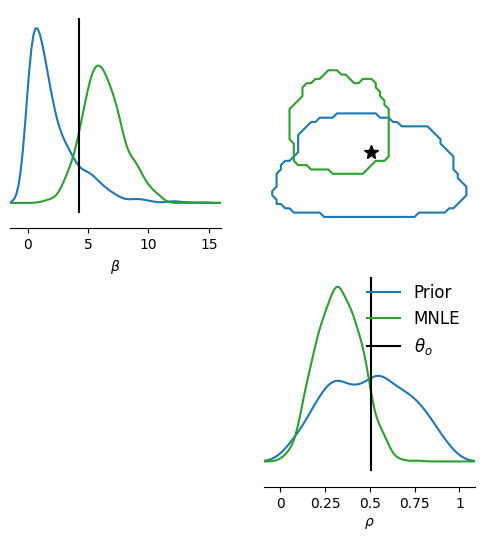

In [25]:
fig, ax = pairplot(
    [
        prior.sample((1000,)),
        mnle_samples,
    ],
    points=theta_o,
    diag="kde",
    upper="contour",
    upper_kwargs=dict(levels=[0.95]),
    diag_kwargs=dict(bins=100),
    fig_kwargs=dict(
        points_offdiag=dict(marker="*", markersize=10),
        points_colors=["k"],
    ),
    labels=[r"$\beta$", r"$\rho$"],
    figsize=(6, 6),
)

plt.sca(ax[1, 1])
plt.legend(
    ["Prior", "MNLE", r"$\theta_o$"],
    frameon=False,
    fontsize=12,
);

In [26]:
theta_o

tensor([[4.2575, 0.5076]])